# Bayesian Gaussian Process fits tutorial

In [1]:
import qnmfits
import numpy as np
import scipy
import corner
import bgp_qnm_fits as bgp 

We start by importing a simulation (as a qnmfits.Custom object) and definining the parameters of our model. 

In [2]:
ID = "0001"
sim_main = bgp.SXS_CCE(ID, lev="Lev5", radius="R2")
CHIF_MAG = sim_main.chif_mag
MF = sim_main.Mf

N_MAX = 7
qnm_list = [(2,2,n,1) for n in np.arange(0, N_MAX+1)]
spherical_modes = [(2, 2)]

T0 = 17
T = 100

For the noise kernel, we can import files that contain the pre-trained parameters. 

We use the subscript 
'WN' to denote the white noise kernel,
'GP' to denote the 'main' or 'standard' kernel, 
'GPc' to denote the `complicated' kernel. 

In [3]:
tuned_param_dict_WN = bgp.get_param_data("WN")[ID]
tuned_param_dict_GP = bgp.get_param_data("GP")[ID]

Let's now perform a basic BGP fit and compare this to the LS fit. 

We use 'BGP' as shorthand for the Bayesian fit with a GP noise model, and 'LS' for least-squares. 

We note the following features of the BGP_fit class:

- We have to specify the param dictionary and the the kernel as two separate arguments. 
- We can specify t0 either as a single value or a list. In the latter case, a list of fits is returned. 
- We can toggle use_nonlinear_params to switch between using the ABD (NR) values of the mass and spin as 
    reference values about which to perform the linearised expansion of the model, or the nonlinear values
    obtained from a least-squares minimisation. The default is the former and the latter takes signficantly 
    longer with only a small improvement in accuracy. 
- We can toggle the inclusion of chif and Mf as free parameters in the linear model. When they are included, 
they appear at the end of any parameter list: $[\rm Re(A_1), \rm Im(A_1), \rm Re(A_2), \rm Im(A_2), \dots, \chi_f, M_f]$.

In [ ]:
ref_fit_LS = qnmfits.multimode_ringdown_fit(
    sim_main.times,
    sim_main.h,
    qnm_list,
    MF,
    CHIF_MAG,
    T0,
    T=T,
    spherical_modes=spherical_modes,
)

ref_fit_WN = bgp.BGP_fit(
    sim_main.times,
    sim_main.h,
    qnm_list,
    MF,
    CHIF_MAG,
    tuned_param_dict_WN,
    bgp.kernel_WN,
    t0=T0,
    use_nonlinear_params=False,
    num_samples=int(1e4),
    t0_method="geq",
    T=T,
    spherical_modes=spherical_modes,
    include_chif=True,
    include_Mf=True,
)

ref_fit_GP = bgp.BGP_fit(
    sim_main.times,
    sim_main.h,
    qnm_list,
    MF,
    CHIF_MAG,
    tuned_param_dict_GP,
    bgp.kernel_GP,
    t0=T0,
    use_nonlinear_params=False,
    num_samples=int(1e4),
    t0_method="geq",
    T=T,
    spherical_modes=spherical_modes,
    include_chif=True,
    include_Mf=True,
)

In [10]:
samples_WN = np.array(ref_fit_WN.fit["samples"])
samples_GP = np.array(ref_fit_GP.fit["samples"])
amplitudes_LS = ref_fit_LS["C"]

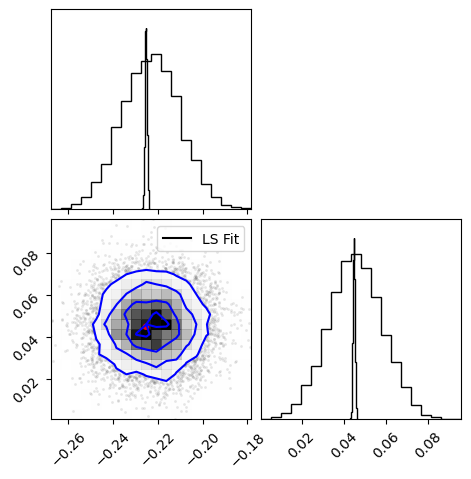

In [ ]:
figure = corner.corner(
    samples_GP[:, 0:2],
    colors='red',
    plot_contours=True,
    contour_kwargs={"colors": "red"},
)

figure2 = corner.corner(
    samples_WN[:, 0:2],
    fig=figure,
    plot_contours=True,
    contour_kwargs={"colors": "blue"},
)

figure2.axes[2].plot(amplitudes_LS[0].real, amplitudes_LS[0].imag, color='black', marker='o', markersize=10, label='LS Fit')
figure2.axes[2].legend()